In [13]:
import numpy as np
import os
from tqdm import tqdm_notebook
import h5py
import time
from sklearn.model_selection import train_test_split
import gc
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard

In [2]:
seed = 0
num_categories = 20
num_epochs = 500
batch_size = 64

In [34]:
def scheduler(epoch):
    if epoch < 200:
        return 0.01
    if epoch < 400:
        return 0.005
    return 0.001

# Callback for tensorboard
tb_cb = TensorBoard(log_dir='./age_cnn_large', histogram_freq=0)

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                           save_weights_only=True,
                                           verbose=1,
                                           epochs_pr_checkpoint=50)

# callback for learning rate 
change_lr_cb = LearningRateScheduler(scheduler)

cbks = [cp_cb, tb_cb, change_lr_cb]

In [4]:
def categorize(ages,categories=20):
    ages_copy=np.array(ages,copy=True)
    for i in range(len(ages)):
        if ages_copy[i] < 0:
            ages_copy[i] = 0
        elif ages_copy[i] > 99:
            ages_copy[i] = categories+1
        else:
            ages_copy[i] = ages_copy[i]//(100/categories)+1
    categorical = to_categorical(ages_copy)
    return categorical

In [5]:
def load_data():
    with h5py.File('imdb_preprocesed_1.hdf5', 'r') as f:
        i1_ages = np.array(f.get('ages'))
        i1_images = np.array(f.get('images'))

    print("Part 1 done!")

    with h5py.File('imdb_preprocesed_2.hdf5', 'r') as f:
        i2_ages = np.array(f.get('ages'))
        i2_images = np.array(f.get('images'))

    print("Part 2 done!")

    with h5py.File('wiki_preprocesed.hdf5', 'r') as f:
        w_ages = np.array(f.get('ages'))
        w_images = np.array(f.get('images'))

    print("Load done!\nCreating dataset")
    gc.collect()
    
    images = np.concatenate([i1_images,i2_images, w_images])
    ages = np.concatenate([i1_ages, i2_ages, w_ages])
    
    ages = categorize(ages, categories=num_categories)
    
    x_train, x_test, y_train, y_test = train_test_split(images, ages, test_size = 0.1, random_state=seed)
    print("All done!")
    gc.collect()
    return x_train, x_test, y_train, y_test

In [6]:
# load and split the data
x_train, x_test, y_train, y_test = load_data()

# split the training in train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=seed)

Part 1 done!
Part 2 done!
Load done!
Creating dataset
All done!


In [35]:
def createConvModel(inputDimensions, outputDimensions):
    model = Sequential()
    
    # Convblock 1
    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=inputDimensions))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=inputDimensions))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
        
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # Convblock 2
    model.add(Conv2D(128, kernel_size=3, padding='same', input_shape=inputDimensions))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(128, kernel_size=3, padding='same', input_shape=inputDimensions))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # Convblock 3
    model.add(Conv2D(256, kernel_size=3, padding='same', input_shape=inputDimensions))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(256, kernel_size=3, padding='same', input_shape=inputDimensions))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(256, kernel_size=3, padding='same', input_shape=inputDimensions))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(256, kernel_size=3, padding='same', input_shape=inputDimensions))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # Conv block 4
    model.add(Conv2D(512, kernel_size=3, padding='same', input_shape=inputDimensions))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # Dense finale
    model.add(Flatten())
    
    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(outputDimensions, activation="softmax"))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [36]:
model = createConvModel(x_train[0].shape, y_train.shape[1]) 

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_44 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
activation_44 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_45 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
activation_45 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 64)       

In [ ]:
model.fit(x_train,
          y_train,
          validation_data=(x_val, y_val),
          epochs=num_epochs,
          callbacks=cbks,
          batch_size=batch_size)


Train on 423670 samples, validate on 47075 samples
Epoch 1/500
423552/423670 [============================>.] - ETA: 0s - loss: 2.3869 - accuracy: 0.1697
Epoch 00001: saving model to training_1/cp.ckpt
423670/423670 [==============================] - 198s 467us/sample - loss: 2.3868 - accuracy: 0.1697 - val_loss: 2.3579 - val_accuracy: 0.1748
Epoch 2/500
423616/423670 [============================>.] - ETA: 0s - loss: 2.2544 - accuracy: 0.1908
Epoch 00002: saving model to training_1/cp.ckpt
423670/423670 [==============================] - 196s 462us/sample - loss: 2.2544 - accuracy: 0.1908 - val_loss: 2.2980 - val_accuracy: 0.1801
Epoch 3/500
423616/423670 [============================>.] - ETA: 0s - loss: 2.1928 - accuracy: 0.2085
Epoch 00003: saving model to training_1/cp.ckpt
423670/423670 [==============================] - 195s 461us/sample - loss: 2.1928 - accuracy: 0.2085 - val_loss: 2.1910 - val_accuracy: 0.2111
Epoch 4/500
423616/423670 [============================>.] - ETA: 0

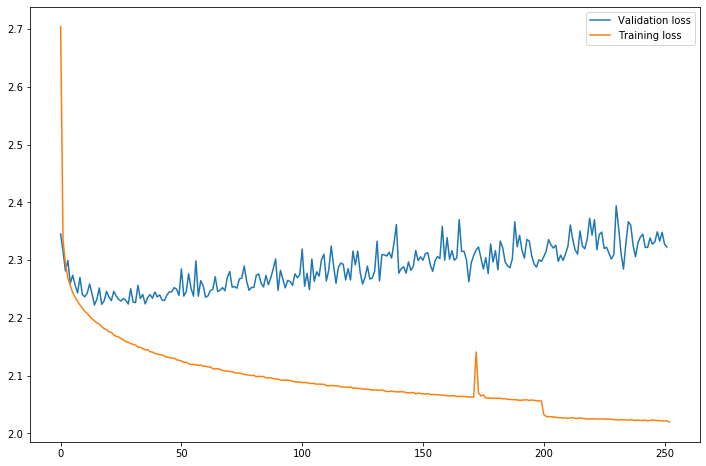

In [14]:
# loss history for simple cnn model
cnn_history = model.history.history
plt.figure(figsize=(12, 8))
plt.plot(cnn_history["val_loss"], label="Validation loss")
plt.plot(cnn_history["loss"], label="Training loss")
plt.legend();

In [18]:
cnn_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

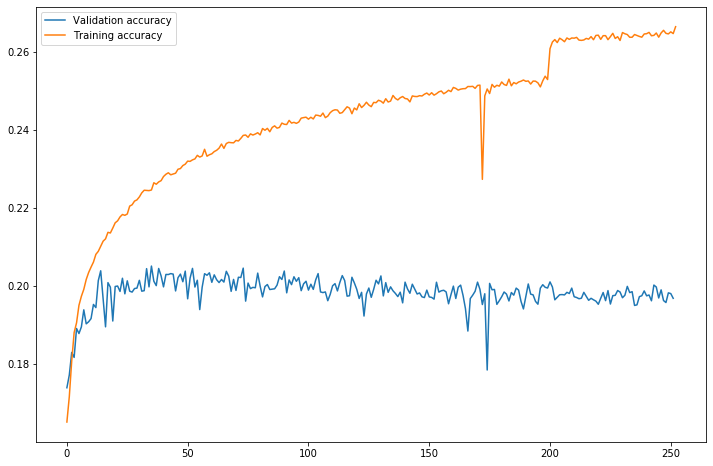

In [19]:
# accuracy history
plt.figure(figsize=(12, 8))
plt.plot(cnn_history["val_accuracy"], label="Validation accuracy")
plt.plot(cnn_history["accuracy"], label="Training accuracy")
plt.legend();

## Warning, do not run until the model is done!!!

In [ ]:
# final metrics for the model computed on the test set
final_model_metrics = model.evaluate(x_test, y_test)